<a href="https://colab.research.google.com/github/o7s8r6/000AIGenIvaan/blob/main/LLM_Fine_Tuning_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Required Libraries for Fine tuning

In [ ]:
!pip install -q -U bitsandbytes peft trl accelerate datasets transformers

Import the libraries

In [ ]:
import os
import transformers
import torch
from google.colab import userdata #optional for adding API Tokens
from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig,get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,pipeline

Load Tokenizer & Model from Hugging Face using BitsAndBytesConfig

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
model_id = "mistralai/Mistral-7B-v0.1"  #provide the model id from hugging face
tokenizer = AutoTokenizer.from_pretrained( #add token=os.environ['API_TOKEN'] if required
    model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=bnb_config,
                                             device_map={"":0},
                                             ) # add token=os.environ['HF_TOKEN'] if required

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Test whether Model is working or or not

In [ ]:
text = "As a data scientist, can you explain the concept of regularization in machine learning?"
device = "cuda:0"
inputs = tokenizer(text, return_tensors="pt").to(device)

outputs = model.generate(**inputs, max_new_tokens=100,temperature=0.7,top_k=50,top_p=0.95,num_return_sequences=1)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


As a data scientist, can you explain the concept of regularization in machine learning?м

Regularization is a technique used in machine learning to prevent overfitting and improve the generalization ability of a model. Overfitting occurs when a model fits the training data too closely, resulting in poor performance on unseen data. Regularization helps to prevent overfitting by adding a penalty term to the loss function, which encourages the model to be simpler and less complex.

There are several types of regularization techniques, including L1 and L2 regularization


Load the Custom Dataset and the format needs to be matched for training & Test Data

In [ ]:
from datasets import load_dataset

data = load_dataset('csv', data_files='Custom_Train_data_set.csv', split='train',encoding='latin-1')
data = data.map(lambda samples: tokenizer(samples["Description"]), batched=True)

Check what is inside Data

In [ ]:
data

Dataset({
    features: ['Product', 'Description', 'input_ids', 'attention_mask'],
    num_rows: 24
})

In [ ]:
data['Description'][0]

"Introducing our new eco-friendly bamboo toothbrush! Crafted from sustainable bamboo, it's not only good for your teeth but also for the planet. Say goodbye to plastic..."

In [ ]:
data['Product'][0]

'Eco-Friendly Bamboo Toothbrush'

Check out Frequency of Input data lengths

24


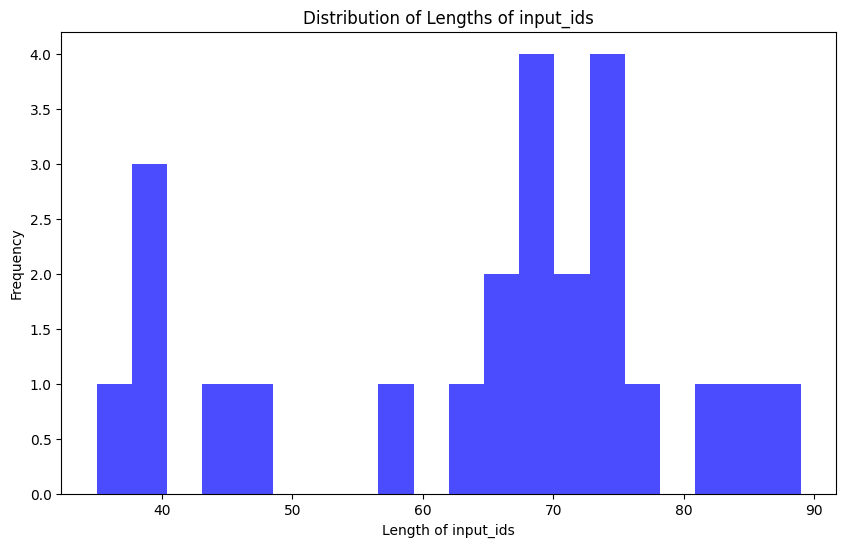

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(data):
    lengths = [len(x['input_ids']) for x in data]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(data)

Max length of input ids is around 90

In [ ]:
def formatting_func_data_distribution(example): #wrte a func to format the data for mapping the maxlength
    text = f"Product: {example['Product'][0]}\n Description: {example['Description'][0]}"
    return text

In [ ]:
def formatting_func(example): #formatting function for Training arguments
    text = f"Product: {example['Product'][0]}\n Description: {example['Description'][0]}"
    return [text]

In [ ]:
max_length = 85 # set this appropriately for your dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func_data_distribution(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
data = data.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

In [ ]:
print(data[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 9068, 28747, 451, 13, 10220, 28747, 413, 2]


24


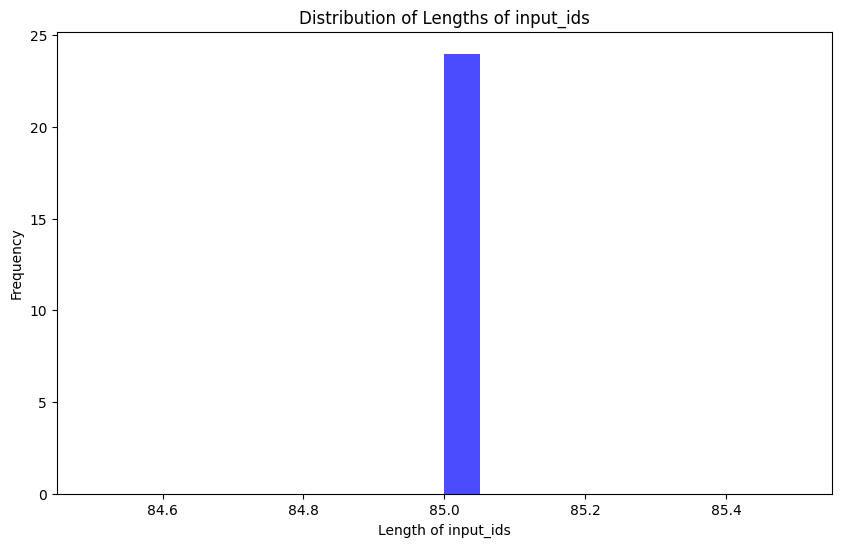

In [ ]:
plot_data_lengths(data)

Setup Training Configuration

*   Lora Config
*   Training Args
*   SFTTrainer





In [ ]:
lora_config = LoraConfig(
    r = 8,
    target_modules = ["q_proj", "o_proj", "k_proj", "v_proj",
                      "gate_proj", "up_proj", "down_proj"],
    task_type = "CAUSAL_LM",
)

Check the changes in model

In [ ]:
model = get_peft_model(model, lora_config)
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=40

In [ ]:
training_args = transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=10,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    )

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=data,
    args=training_args,
    peft_config=lora_config,
    formatting_func=formatting_func,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:225: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/24 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:294: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


Train the model using trainer.train() method

In [ ]:
trainer.train()

Step,Training Loss
1,0.357900
2,0.357900
3,0.291600
4,0.176100
5,0.108700
6,0.075700
7,0.052200
8,0.043800
9,0.040400
10,0.038700


TrainOutput(global_step=10, training_loss=0.15429169237613677, metrics={'train_runtime': 8.7092, 'train_samples_per_second': 4.593, 'train_steps_per_second': 1.148, 'total_flos': 26101771714560.0, 'train_loss': 0.15429169237613677, 'epoch': 10.0})

Test the model with new prompts

In [ ]:
text = "Organic Cotton Baby Onesies"
device = "cuda:0"
inputs = tokenizer(text, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=100,temperature=0.1,top_k=50,top_p=0.95)
print(tokenizer.decode(outputs[0],skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Organic Cotton Baby Onesiesтр

# Organic Cotton Baby Onesies интернет-магазин

## Organic Cotton Baby Onesies

Organic cotton baby onesies are a great choice for parents who want to dress their little ones in eco-friendly and sustainable clothing. Made from organic cotton, these onesies are not only soft and comfortable but also good for the planet. In this article, we'll explore the benefits of organic cotton baby onesies


Save the Model

In [ ]:
trainer.model.save_pretrained('model')

In [ ]:
!huggingface-cli login

model.push_to_hub("Asheesh18/Mistral_trained", check_pr=True)

tokenizer.push_to_hub("Asheesh18/Mistral_trained",check_pr=True)


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.c

adapter_model.safetensors:   0%|          | 0.00/83.9M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Asheesh18/Mistral_trained/commit/0b3a0f13060477d35e464a4c1cd283b8dd13fbd5', commit_message='Upload tokenizer', commit_description='', oid='0b3a0f13060477d35e464a4c1cd283b8dd13fbd5', pr_url=None, pr_revision=None, pr_num=None)